In [1]:
from collections import defaultdict
import itertools
import json
from pathlib import Path
import random

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm

In [2]:
def parse(root):
    raw = {}
    for path in Path(root).iterdir():
        with open(f"{path}/config.json") as f:
            config = json.load(f)
        raw[path.name] = config
    config_df = pd.DataFrame(raw).T.sort_index()
    return config_df

In [3]:
root = "store/2023-04-08__camelyon17"

In [4]:
config_df = parse(root)

In [5]:
config_df.query("done == True")[["seed", "done"]]

,seed,done
1680993024005414658,0,True
1680993026169437137,1,True
1680993029435033366,3,True
1680993030752785424,4,True
1680993034134008175,5,True
1680993036097668734,6,True
1680993038597520958,8,True
1680993162962885041,2,True
1680993169587993962,7,True


In [6]:
runs = config_df.query("done == True").index
len(runs)

9

In [31]:
split = "id_val"
y = torch.load(f"{root}/{runs[0]}/epochs/0/{split}_y.pt", map_location="cpu")
num_classes = y.max().item() + 1
num_classes

2

In [32]:
epochs = len(list(Path(f"{root}/{runs[0]}/epochs/").iterdir()))
epochs

10

In [34]:
yhat = torch.empty(epochs, len(runs), y.size(0), num_classes)
for epoch in tqdm(range(epochs)):
    for i, run in enumerate(runs):
        yhat[epoch, i] = torch.load(f"{root}/{run}/epochs/{epoch}/{split}_yhat.pt", map_location="cpu")

  0%|          | 0/10 [00:00<?, ?it/s]

In [35]:
Y = defaultdict(lambda: torch.empty(epochs))
Zm = defaultdict(lambda: torch.empty(epochs))
ZM = defaultdict(lambda: torch.empty(epochs))
for ens_sz in range(1,10):
    for epoch in tqdm(range(epochs), desc=str(ens_sz)):
        combs = list(itertools.combinations(torch.arange(9), ens_sz))
        # samples = random.sample(combs, min(len(combs), 40))
        samples = combs
        errs = []
        for idx in samples:
            ens_yhat = yhat[epoch, idx].mean(0)
            err = (ens_yhat.argmax(-1) != y).float().mean()
            errs.append(err)
        err = torch.as_tensor(errs)
        Y[ens_sz][epoch] = err.mean()
        Zm[ens_sz][epoch] = err.min()
        ZM[ens_sz][epoch] = err.max()

1:   0%|          | 0/10 [00:00<?, ?it/s]

2:   0%|          | 0/10 [00:00<?, ?it/s]

3:   0%|          | 0/10 [00:00<?, ?it/s]

4:   0%|          | 0/10 [00:00<?, ?it/s]

5:   0%|          | 0/10 [00:00<?, ?it/s]

6:   0%|          | 0/10 [00:00<?, ?it/s]

7:   0%|          | 0/10 [00:00<?, ?it/s]

8:   0%|          | 0/10 [00:00<?, ?it/s]

9:   0%|          | 0/10 [00:00<?, ?it/s]

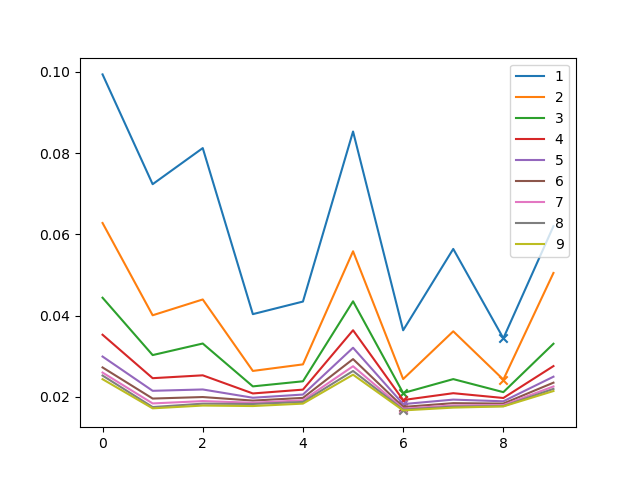

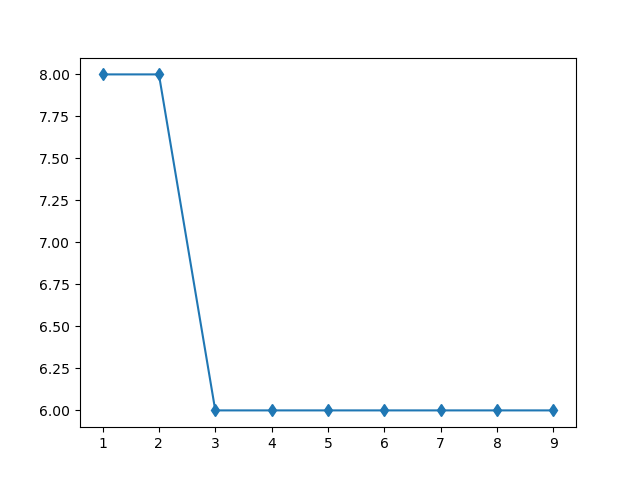

In [36]:
%matplotlib widget
plt.figure()
for ens_sz in range(1,10):
    plt.plot(Y[ens_sz], label=ens_sz)
    # plt.fill_between(torch.arange(epochs), Y[ens_sz]-Z[ens_sz], Y[ens_sz]+Z[ens_sz], alpha=0.3)
    # plt.fill_between(torch.arange(epochs), Zm[ens_sz], ZM[ens_sz], alpha=0.3)
plt.gca().set_prop_cycle(None)
for ens_sz in range(1,9):
    plt.scatter(Y[ens_sz].argmin(), Y[ens_sz].min(), marker="x")
plt.legend()
plt.show()
plt.figure()
plt.plot([k for k in Y.keys()], [v.argmin() for v in Y.values()], marker="d")
plt.show()